# NYC_Parking_Violations_IBM_Capstone
## Notebook 3
## Models to predict top four Violation Categories

In [1]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3"
os.environ["JAVA_HOME"] = "/Library/java/JavaVirtualMachines/adoptopenjdk-8.jdk/contents/Home/"

In [2]:
import findspark
findspark.init()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, MinMaxScaler, VectorAssembler)
from pyspark.ml.classification import (
    DecisionTreeClassifier, RandomForestClassifier)

from sklearn.preprocessing import MinMaxScaler as SkMinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName('NYC_Parking').getOrCreate()

In [6]:
df = spark.read.csv('nyc_sampled.csv',inferSchema=True,header=True)

In [7]:
df.printSchema()

root
 |-- State: string (nullable = true)
 |-- License_Type: string (nullable = true)
 |-- Violation: string (nullable = true)
 |-- Fine Amount: double (nullable = true)
 |-- Penalty Amount: double (nullable = true)
 |-- Reduction Amount: double (nullable = true)
 |-- Payment Amount: double (nullable = true)
 |-- Amount Due: double (nullable = true)
 |-- Precinct: integer (nullable = true)
 |-- County: string (nullable = true)
 |-- Issuing_Agency: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)



In [8]:
# Index categorical columns
cat_columns = ['State',
               'License_Type',
               'Violation',
               'County',
               'Issuing_Agency']

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index")
            for column in cat_columns]

pipeline = Pipeline(stages=indexers)

df_indexed = pipeline.fit(df).transform(df).drop(*cat_columns)

In [9]:
df_pd = df_indexed.toPandas()

In [10]:
X = df_pd.drop('Violation_index', axis=1).values
y = df_pd[['Violation_index']].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape

(778248, 13)

In [13]:
X_test.shape

(194563, 13)

## Deep Learning model

In [14]:
scaler = SkMinMaxScaler()

In [15]:
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
model = Sequential()

model.add(Dense(13, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(4, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['sparse_categorical_accuracy'])

In [18]:
model.fit(x=X_train,y=y_train,epochs = 20,validation_data=(X_test,y_test))

Train on 778248 samples, validate on 194563 samples
Epoch 1/20
778248/778248 [==============================] - 44s 56us/sample - loss: 0.1021 - sparse_categorical_accuracy: 0.9528 - val_loss: 0.0513 - val_sparse_categorical_accuracy: 0.9721
Epoch 2/20
778248/778248 [==============================] - 43s 55us/sample - loss: 0.0508 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.0493 - val_sparse_categorical_accuracy: 0.9719
Epoch 3/20
778248/778248 [==============================] - 43s 55us/sample - loss: 0.0487 - sparse_categorical_accuracy: 0.9717 - val_loss: 0.0478 - val_sparse_categorical_accuracy: 0.9721
Epoch 4/20
778248/778248 [==============================] - 47s 61us/sample - loss: 0.0478 - sparse_categorical_accuracy: 0.9720 - val_loss: 0.0471 - val_sparse_categorical_accuracy: 0.9725
Epoch 5/20
778248/778248 [==============================] - 47s 61us/sample - loss: 0.0471 - sparse_categorical_accuracy: 0.9721 - val_loss: 0.0464 - val_sparse_categorical_accuracy: 0.972

### Model Evaluation

accuracy =  0.9735585451126099
val_accuracy =  0.9729753136634827


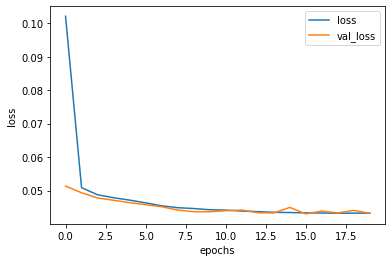

In [19]:
losses_2 = pd.DataFrame(model.history.history)
losses_2[['loss', 'val_loss']].plot()
plt.xlabel('epochs')
plt.ylabel('loss')
print("accuracy = ", losses_2[[
      'sparse_categorical_accuracy']].iloc[-1][0])
print("val_accuracy = ", losses_2[[
      'val_sparse_categorical_accuracy']].iloc[-1][0])

In [20]:
predictions = model.predict_classes(X_test)

In [21]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     60953
         1.0       1.00      1.00      1.00     55167
         2.0       0.96      0.92      0.94     42863
         3.0       1.00      1.00      1.00     35580

    accuracy                           0.97    194563
   macro avg       0.98      0.97      0.97    194563
weighted avg       0.97      0.97      0.97    194563



## Decision Tree and Random Forest Models

In [22]:
# Prepare stages for ML Pipeline
stages = []

# Transform columns into a single vector column.
vect_assembler_inputs = df_indexed.drop('Violation_index').columns
assembler = VectorAssembler(
    inputCols=vect_assembler_inputs, outputCol="features")

stages += [assembler]

# Rescale  each feature into the range from 0 to 1.
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

stages += [scaler]


# Instantiate classifiers
dtc = DecisionTreeClassifier(
    labelCol='Violation_index', featuresCol='scaled_features')
rfc = RandomForestClassifier(
    labelCol='Violation_index', featuresCol='scaled_features')

# Set stages for classifiers
stages_dtc = stages + [dtc]
stages_rfc = stages + [rfc]

In [23]:
# Set the stages for ML Pipeline
pipeline_dtc = Pipeline().setStages(stages_dtc)
pipeline_rfc = Pipeline().setStages(stages_rfc)

In [24]:
train, test = df_indexed.randomSplit([0.8, 0.2], seed=42)

In [25]:
dtc_model = pipeline_dtc.fit(train)
rfc_model = pipeline_rfc.fit(train)

In [26]:
dtc_preds = dtc_model.transform(test)
rfc_preds = rfc_model.transform(test)

In [27]:
df_dtc = dtc_preds.toPandas()
df_rfc = rfc_preds.toPandas()

### Model Evaluation
#### Decision Tree

In [28]:
print(classification_report(
    df_dtc['Violation_index'].values, df_dtc['prediction'].values))

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     60892
         1.0       1.00      1.00      1.00     54831
         2.0       0.87      1.00      0.93     43099
         3.0       1.00      1.00      1.00     35555

    accuracy                           0.97    194377
   macro avg       0.97      0.97      0.97    194377
weighted avg       0.97      0.97      0.97    194377



#### Random Forest

In [29]:
print(classification_report(
    df_rfc['Violation_index'].values, df_rfc['prediction'].values))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     60892
         1.0       1.00      1.00      1.00     54831
         2.0       0.97      0.87      0.91     43099
         3.0       1.00      1.00      1.00     35555

    accuracy                           0.96    194377
   macro avg       0.97      0.96      0.96    194377
weighted avg       0.97      0.96      0.96    194377

